常见的2D图像变换从原理上讲主要包括基于2×3矩阵的仿射变换和基于3×3矩阵透视变换。
## 仿射变换
基本的图像变换就是二维坐标的变换：从一种二维坐标(x,y)到另一种二维坐标(u,v)的线性变换：
```
u = a1*x + b1*y + c1
v = a2*x + b2*y + c2
```
如果写成矩阵的形式，就是：
```
[ u ] = [ a1 b1 ][ x ] + [ c1 ]
  v       a2 b2    y       c2
```
作如下定义：
```
R = [ a1 b1 ], t = [ c1 ], T = [ R t ]
      a2 b2          c2
```
矩阵T(2×3)就称为仿射变换的变换矩阵，R为线性变换矩阵，t为平移矩阵，简单来说，仿射变换就是线性变换+平移。变换后直线依然是直线，平行线依然是平行线，直线间的相对位置关系不变，因此非共线的三个对应点便可确定唯一的一个仿射变换，线性变换4个自由度+平移2个自由度→仿射变换自由度为6。
![](http://blog.codec.wang/cv2_warp_affine_image_sample_introduction2.jpg)
来看下OpenCV中如何实现仿射变换：

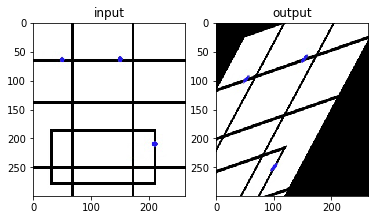

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('drawing.jpg')
rows, cols = img.shape[:2]

# 变换前的三个点
pts1 = np.float32([[50, 65], [150, 65], [210, 210]])
# 变换后的三个点
pts2 = np.float32([[50, 100], [150, 65], [100, 250]])

# 生成变换举证
M = cv2.getAffineTransform(pts1, pts2)
dst = cv2.warpAffine(img, M, (cols, rows))

plt.subplot(121), plt.imshow(img),plt.title('input')
plt.subplot(122), plt.imshow(dst), plt.title('output')
plt.show()

三个点我已经在图中标记了出来。用cv2.getAffineTransform()生成变换矩阵，接下来再用cv2.warpAffine()实现变换。

其实平移、旋转、缩放和翻转等变换就是对应了不同的仿射变换矩阵，下面分别来看下。
![](http://blog.codec.wang/cv2_image_transformation_sample.jpg)

## 平移
![](http://blog.codec.wang/cv2_warp_affine_shift_sample.jpg)
平移就是x和y方向上的直接移动，可以上下/左右移动，自由度为2，变换矩阵可以表示为：
```
[ u ] = [ 1 0 ][ x ] + [ tx ]
  v       0 1    y       ty
```
## 旋转
![](http://blog.codec.wang/cv2_warp_affine_rotation_sample.jpg)
旋转是坐标轴方向饶原点旋转一定的角度θ，自由度为1，不包含平移，如顺时针旋转可以表示为：
```
[ u ] = [ cosθ −sinθ ][ x ] + [ 0 ]
  v       sinθ  cosθ    y       0
```
思考：如果不是绕原点，而是可变点，自由度是多少呢？（请看下文刚体变换）

## 翻转
翻转是x或y某个方向或全部方向上取反，自由度为2，比如这里以垂直翻转为例：
```
[ u ] = [ 1   0 ][ x ] + [ 0 ]
  v       0  -1    y       0
```

## 刚体变换
旋转+平移也称刚体变换（Rigid Transform），就是说如果图像变换前后两点间的距离仍然保持不变，那么这种变化就称为刚体变换。刚体变换包括了平移、旋转和翻转，自由度为3。变换矩阵可以表示为：
```
[ u ] = [ cosθ −sinθ ][ x ] + [ tx ]
  v       sinθ  cosθ    y       ty
```
由于只是旋转和平移，刚体变换保持了直线间的长度不变，所以也称欧式变换（变化前后保持欧氏距离）。

## 缩放
![](http://blog.codec.wang/cv2_warp_affine_scale_sampel.jpg)
缩放是x和y方向的尺度（倍数）变换，在有些资料上非等比例的缩放也称为拉伸/挤压，等比例缩放自由度为1，非等比例缩放自由度为2，矩阵可以表示为：
```
[ u ] = [ sx  0 ][ x ] + [ 0 ]
  v       0   sy   y       0
```

## 相似变换
相似变换又称缩放旋转，相似变换包含了旋转、等比例缩放和平移等变换，自由度为4。在OpenCV中，旋转就是用相似变换实现的：

若缩放比例为scale，旋转角度为θ，旋转中心是(center(x),center(y))，则仿射变换可以表示为：
```
[ u ] = [ α  β ][ x ] + [ (1−α)center(x)−βcenter(y) ]
  v      −β  α    y       βcenter(x)+(1−α)center(y)
```
其中，
```
α = scale⋅cosθ ,β = scale⋅sinθ
```
相似变换相比刚体变换加了缩放，所以并不会保持欧氏距离不变，但直线间的夹角依然不变。

经验之谈：OpenCV中默认按照逆时针旋转噢~

总结一下（原图[#计算机视觉：算法与应用p39]）：

变换|     矩阵|	            自由度|	        保持性质
-|-|-|-
平移|	[I, t]（2×3）|	    2|      方向/长度/夹角/平行性/直线性
刚体|	[R, t]（2×3）|	    3|      长度/夹角/平行性/直线性
相似|	[sR, t]（2×3）|	4|      夹角/平行性/直线性
仿射|	[T]（2×3）	|       6|      平行性/直线性
透视|	[T]（3×3）	|       8|      直线性

## 透视变换
前面仿射变换后依然是平行四边形，并不能做到任意的变换。
![](http://blog.codec.wang/cv2_warp_perspective_image_sample4.jpg)

透视变换（Perspective Transformation）是将二维的图片投影到一个三维视平面上，然后再转换到二维坐标下，所以也称为投影映射（Projective Mapping）。简单来说就是二维→三维→二维的一个过程
```
X = a1*x + b1*y + c1
Y = a2*x + b2*y + c2
Z = a3*x + b3*y + c3
```
这次我写成齐次矩阵的形式：
```
⎡ X ⎤   ⎡ a1 b1 c1 ⎤⎡ x ⎤
⎢ Y ⎥ = ⎢ a2 b2 c2 ⎥⎢ y ⎥
⎣ Z ⎦   ⎣ a3 b3 c3 ⎦⎣ 1 ⎦
```

透视变换相比仿射变换更加灵活，变换后会产生一个新的四边形，但不一定是平行四边形，所以需要非共线的四个点才能唯一确定，原图中的直线变换后依然是直线。因为四边形包括了所有的平行四边形，所以透视变换包括了所有的仿射变换。

OpenCV中首先根据变换前后的四个点用cv2.getPerspectiveTransform()生成3×3的变换矩阵，然后再用cv2.warpPerspective()进行透视变换。实战演练一下：

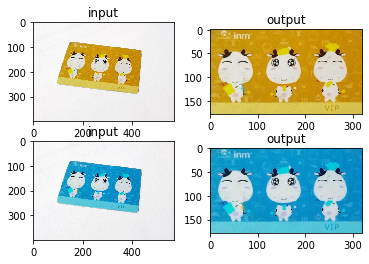

In [4]:
img = cv2.imread('card.jpg')

# 原图中卡片的四个角点
pts1 = np.float32([[148, 80], [437, 114], [94, 247], [423, 288]])
# 变换后分别在左上、右上、左下、右下四个点
pts2 = np.float32([[0, 0], [320, 0], [0, 178], [320, 178]])

# 生成透视变换矩阵
M = cv2.getPerspectiveTransform(pts1, pts2)
# 进行透视变换，参数3是目标图像大小
dst = cv2.warpPerspective(img, M, (320, 178))

plt.subplot(221), plt.imshow(img[:, :, ::-1]), plt.title('input')
plt.subplot(222), plt.imshow(dst[:, :, ::-1]), plt.title('output')
# RGB和BGR变换
plt.subplot(223), plt.imshow(img), plt.title('input')
plt.subplot(224), plt.imshow(dst), plt.title('output')
plt.show()

代码中有个img[:, :, ::-1]还记得吗？忘记的话，请看练习。

当然，我们后面学习了特征提取之后，就可以自动识别角点了。透视变换是一项很酷的功能。比如我们经常会用手机去拍身份证和文件，无论你怎么拍，貌似都拍不正或者有边框。如果你使用过手机上面一些扫描类软件，比如”扫描全能王“，”Office Lens“，它们能很好地矫正图片，这些软件就是应用透视变换实现的。
